Projeto 1 da disciplina IF697 Introdução à Ciência de Dados.

Estudante: Eduardo Geber

## About Dataset

Description: This dataset contains information on the performance of high school students in mathematics, including their grades and demographic information. The data was collected from three high schools in the United States.

Columns:

• Gender: The gender of the student (male/female)

• Race/ethnicity: The student's racial or ethnic background (Asian, African-American, Hispanic, etc.)

• Parental level of education: The highest level of education attained by the student's parent(s) or guardian(s)

• Lunch: Whether the student receives free or reduced-price lunch (yes/no)

• Test preparation course: Whether the student completed a test preparation course (yes/no)

• Math score: The student's score on a standardized mathematics test

• Reading score: The student's score on a standardized reading test

• Writing score: The student's score on a standardized writing test

This dataset could be used for various research questions related to education, such as examining the impact of parental education or test preparation courses on student performance. It could also be used to develop machine learning models to predict student performance based on demographic and other factors.

Source: http://roycekimmons.com/tools/generated_data/exams

Available at: https://www.kaggle.com/datasets/rkiattisak/student-performance-in-mathematics

## Imports

In [206]:
from textwrap import wrap
from functools import partial
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
from scipy.stats import linregress
from scipy.stats import chi2_contingency

## Utilities

In [207]:
def wrap_labels(labels, length):
    """Wrap the list of lables so that so that each label is made of lines with at most length characters"""
    return ['\n'.join(wrap(l, length)) for l in labels]

In [208]:
def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

def pie(df, name):
    """Plot a pie chart of the column."""
    vc = df[name].value_counts()
    total = len(df.index)
    plt.title(name)
    plt.pie(vc, labels=vc.index, autopct=partial(fmt, total=total))
    plt.show()

In [209]:
def bar(df: pd.DataFrame, column_name: str, normalize=False):
    """Plot an ordered bar chart of the column."""
    vc = df[column_name].value_counts().sort_index()
    if normalize:
        vc /= vc.sum()
    plt.title("Frequency of " + column_name)
    plt.bar(range(1, len(vc.index)+1), height=vc, width=0.8, tick_label=wrap_labels(vc.index, 10))
    plt.show()

In [210]:
def grade_hist(df, name, bin_size):
    """Plot an histogram of one of the three exams grade columns."""
    max_grade = 1
    plt.title(name)
    plt.xlabel('grade')
    plt.ylabel('frequency')
    plt.hist(df[name], bins=[i*bin_size for i in range(int(max_grade/bin_size+1))])
    plt.show()

In [211]:
def curtosis(df, name):
    c = df[name]
    dq = c.quantile(0.75) - c.quantile(0.25)
    dp = c.quantile(0.9) - c.quantile(0.1)
    return dq/(2*dp)

In [212]:
def quantile_plot(df, name):
    """Single-variable quantile plot."""
    c = df[name]
    n = len(df.index)
    ps = [(i-0.5)/n for i in range(1, n+1)]
    qs = [c.quantile(p) for p in ps]
    plt.title(name)
    plt.xlabel('quantile')
    plt.ylabel('value')
    plt.plot(ps, qs, 'k.')
    plt.show()

In [213]:
def symmetry_plot(df, name):
    c = df[name]
    md = c.median()
    ordered = np.sort(c.to_numpy())
    n = len(ordered)
    xs = []
    ys = []
    for i in range(int((n+1)/2)):
        x = ordered[i]
        xs.append(md-x)
        y = ordered[n-1-i]
        ys.append(y-md)
    plt.title("symmetry plot of " + name)
    plt.xlabel('u')
    plt.ylabel('v')
    plt.plot(xs, xs)
    plt.plot(xs, ys, 'k.')
    plt.show()

In [214]:
def r2(df: pd.DataFrame, numerical_col: str, categorical_col: str) -> float:
    grouped = df.groupby(categorical_col)[numerical_col]
    grouped_vars = grouped.var()
    grouped_counts = grouped.count()
    mean_grouped_var = np.average(grouped_vars, weights=grouped_counts)
    total_var = df[numerical_col].var()
    return 1 - mean_grouped_var/total_var

## Setup

In [215]:
link = "https://www.kaggle.com/datasets/rkiattisak/student-performance-in-mathematics"
od.download(link)

Skipping, found downloaded files in ".\student-performance-in-mathematics" (use force=True to force download)


In [216]:
filename = "./student-performance-in-mathematics/exams.csv"
df = pd.read_csv(filename)

## Introduction

In [217]:
df.shape

(1000, 8)

In [218]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [219]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


## Pre-processing

### Type correction

In [220]:
df.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

In [221]:
for c in df.columns:
    if df[c].dtype == 'object':
        print(c)
        df[c] = df[c].astype('category')

gender
race/ethnicity
parental level of education
lunch
test preparation course


In [222]:
df.dtypes

gender                         category
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                        int64
reading score                     int64
writing score                     int64
dtype: object

In [223]:
for c in df.columns:
    if df[c].dtype == 'category':
        print(c)
        print(df[c].cat.categories)
    print()

gender
Index(['female', 'male'], dtype='object')

race/ethnicity
Index(['group A', 'group B', 'group C', 'group D', 'group E'], dtype='object')

parental level of education
Index(['associate's degree', 'bachelor's degree', 'high school',
       'master's degree', 'some college', 'some high school'],
      dtype='object')

lunch
Index(['free/reduced', 'standard'], dtype='object')

test preparation course
Index(['completed', 'none'], dtype='object')






In [224]:
# ordenação de algumas das colunas categóricas

df['parental level of education'] = pd.Categorical(
    df['parental level of education'],
    categories=['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"],
    ordered=True
)
df['race/ethnicity'] = pd.Categorical(
    df['race/ethnicity'],
    categories=['group A', 'group B', 'group C', 'group D', 'group E'],
    ordered=True
)
df['test preparation course'] = pd.Categorical(
    df['test preparation course'],
    categories=['none', 'completed'],
    ordered=True
)
df['lunch'] = pd.Categorical(
    df['lunch'],
    categories=['standard', 'free/reduced'],
    ordered=True
)

In [225]:
for c in df.columns:
    if df[c].dtype == 'category':
        print(c)
        print(df[c].cat.categories)
    print()

gender
Index(['female', 'male'], dtype='object')

race/ethnicity
Index(['group A', 'group B', 'group C', 'group D', 'group E'], dtype='object')

parental level of education
Index(['some high school', 'high school', 'some college', 'associate's degree',
       'bachelor's degree', 'master's degree'],
      dtype='object')

lunch
Index(['standard', 'free/reduced'], dtype='object')

test preparation course
Index(['none', 'completed'], dtype='object')






In [226]:
df_coded = df.copy()
for c in df.columns:
    if df[c].dtype == 'category':
        df_coded[c] = df_coded[c].cat.codes

### Missing values

In [227]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

### Normalization

In [228]:
described = df.describe()
pd.options.display.float_format = "{:.2f}".format
described

,math score,reading score,writing score
count,1000.00,1000.00,1000.00
mean,67.81,70.38,69.14
std,15.25,14.11,15.03
min,15.00,25.00,15.00
25%,58.00,61.00,59.00
50%,68.00,70.50,70.00
75%,79.25,80.00,80.00
max,100.00,100.00,100.00


It is not strictly necessary to normalize since all numerical variables have the same scale (0 to 100). However, it is still useful to set all values between 0 and 1.

In [229]:
df.dtypes

gender                         category
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                        int64
reading score                     int64
writing score                     int64
dtype: object

In [230]:
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] /= 100.0
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,0.59,0.70,0.78
1,male,group D,associate's degree,standard,none,0.96,0.93,0.87
2,female,group D,some college,free/reduced,none,0.57,0.76,0.77
3,male,group B,some college,free/reduced,none,0.70,0.70,0.63
4,female,group D,associate's degree,standard,none,0.83,0.85,0.86


In [231]:
df.dtypes

gender                         category
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                      float64
reading score                   float64
writing score                   float64
dtype: object

In [232]:
df.describe()

,math score,reading score,writing score
count,1000.00,1000.00,1000.00
mean,0.68,0.70,0.69
std,0.15,0.14,0.15
min,0.15,0.25,0.15
25%,0.58,0.61,0.59
50%,0.68,0.70,0.70
75%,0.79,0.80,0.80
max,1.00,1.00,1.00


### Outliers

In the original dataset, all variables are numerical and range between 0 and 100, with both endpoints being achieved. Thus, it is expected that univariate analysis will not be able to detect any outlier, in case one exists.

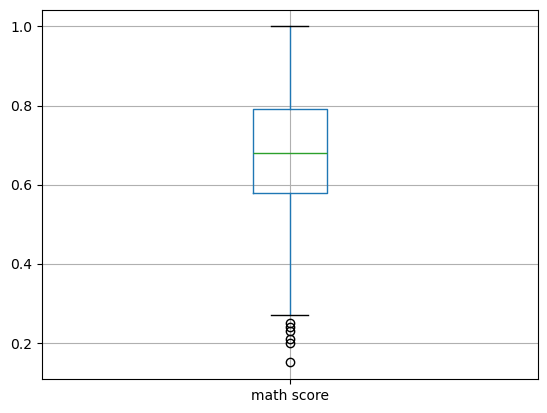

In [233]:
df.boxplot(column='math score')
plt.show()

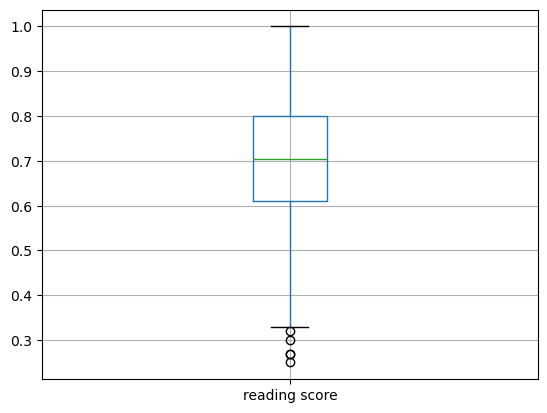

In [234]:
df.boxplot(column='reading score')
plt.show()

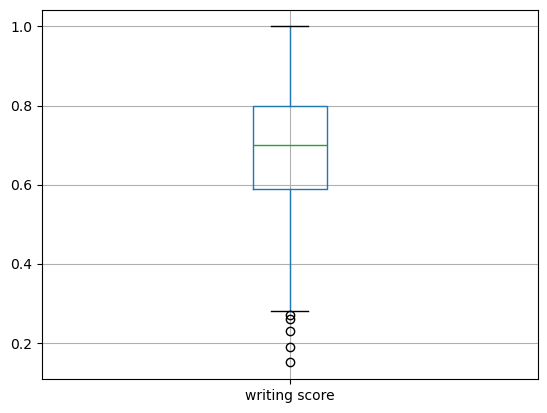

In [235]:
df.boxplot(column='writing score')
plt.show()

In [236]:
fig = ff.create_scatterplotmatrix(df[["writing score", "reading score", "math score"]], diag='histogram', height=700, width=1400)
fig.show()

Bivariate analysis also seems to not reveal any outlier.

In [237]:
# isolation forest


## Descriptive univariate analysis and visualization

### Gender

In [238]:
# valores
df['gender'].unique()

['female', 'male']
Categories (2, object): ['female', 'male']

Pie graphs are usually suitable for unordered categorical variables.

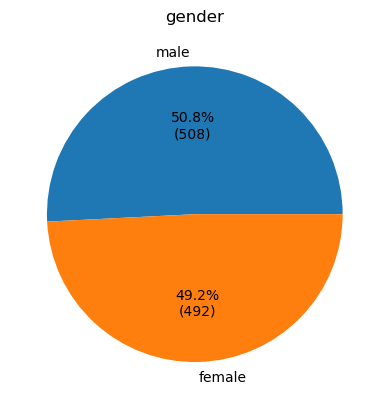

In [239]:
pie(df, 'gender')

### Race/ethnicity

In [240]:
# valores
df['race/ethnicity'].unique()

['group D', 'group B', 'group C', 'group E', 'group A']
Categories (5, object): ['group A' < 'group B' < 'group C' < 'group D' < 'group E']

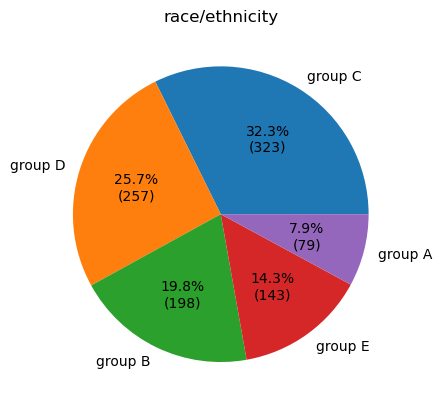

In [241]:
pie(df, 'race/ethnicity')

### Parental level of education

In [242]:
u = df['parental level of education'].unique()
print(len(u))
print(u)

6
['some college', 'associate's degree', 'some high school', 'bachelor's degree', 'master's degree', 'high school']
Categories (6, object): ['some high school' < 'high school' < 'some college' < 'associate's degree' < 'bachelor's degree' < 'master's degree']


Bar graphs are usually suitable for unordered categorical variables.

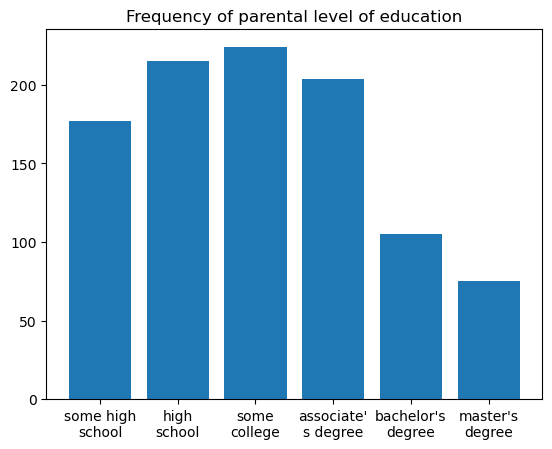

In [243]:
bar(df, 'parental level of education')

### Lunch price

In [244]:
df['lunch'].unique()

['standard', 'free/reduced']
Categories (2, object): ['standard' < 'free/reduced']

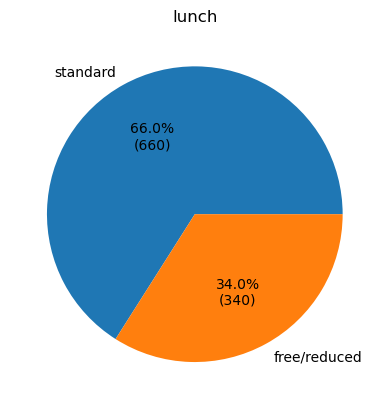

In [245]:
pie(df, 'lunch')

### Test preparation course

In [246]:
df['test preparation course'].unique()

['completed', 'none']
Categories (2, object): ['none' < 'completed']

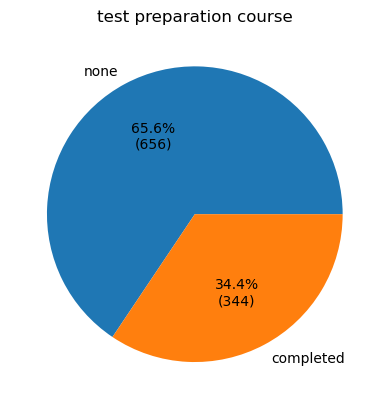

In [247]:
pie(df, 'test preparation course')

### Math score

In [248]:
ms = df['math score']
dms = described['math score']
dms

count   1000.00
mean      67.81
std       15.25
min       15.00
25%       58.00
50%       68.00
75%       79.25
max      100.00
Name: math score, dtype: float64

In [249]:
# Coeficiente de variação
"{:.2f}".format(100*dms['std']/dms['mean']) + '%'

'22.49%'

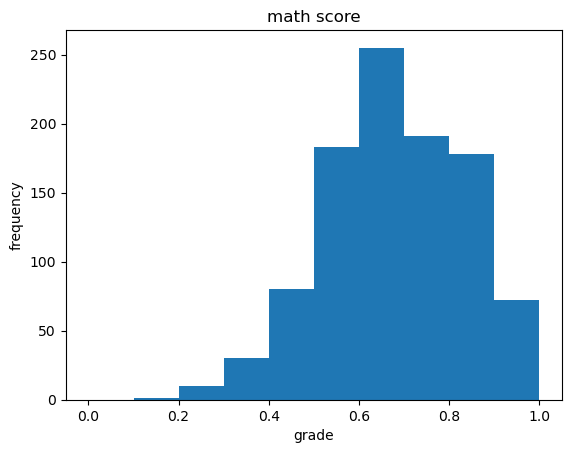

In [250]:
grade_hist(df, 'math score', 0.1)

In [251]:
curtosis(df, 'math score')

0.265625

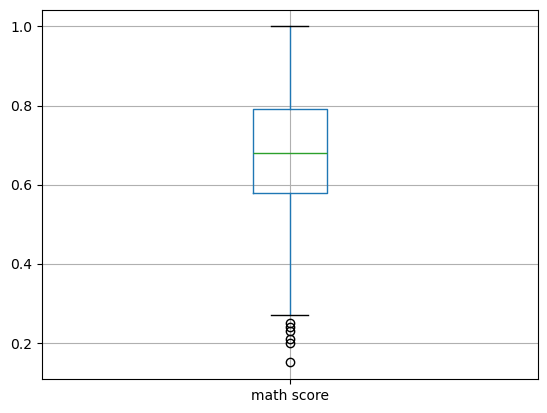

In [252]:
df.boxplot(column='math score')
plt.show()

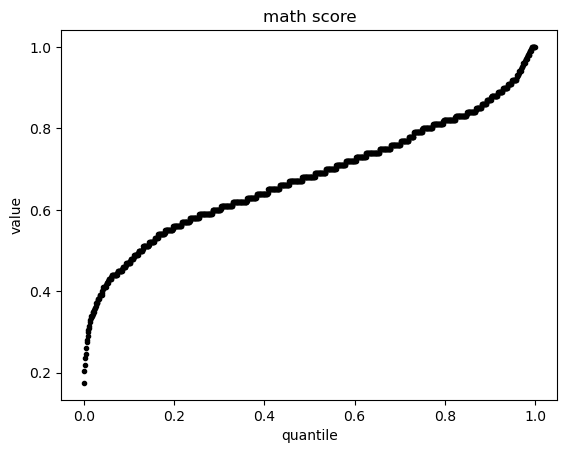

In [253]:
# gráfico de quantil (apenas uma variável)
quantile_plot(df, 'math score')

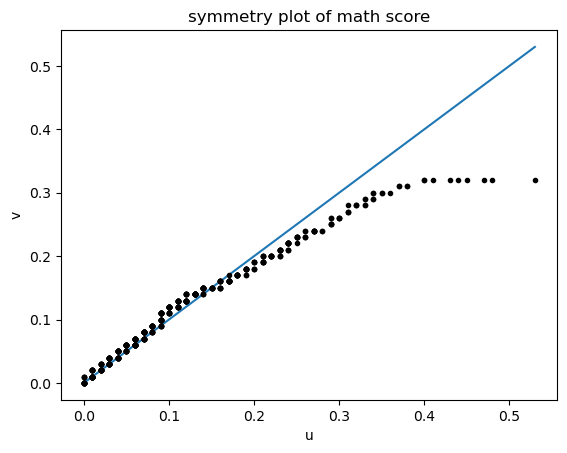

In [254]:
symmetry_plot(df, "math score")

### Reading score

In [255]:
rs = df['reading score']
drs = described['reading score']
drs

count   1000.00
mean      70.38
std       14.11
min       25.00
25%       61.00
50%       70.50
75%       80.00
max      100.00
Name: reading score, dtype: float64

In [256]:
# Coeficiente de variação
"{:.2f}".format(100*drs['std']/drs['mean']) + '%'

'20.04%'

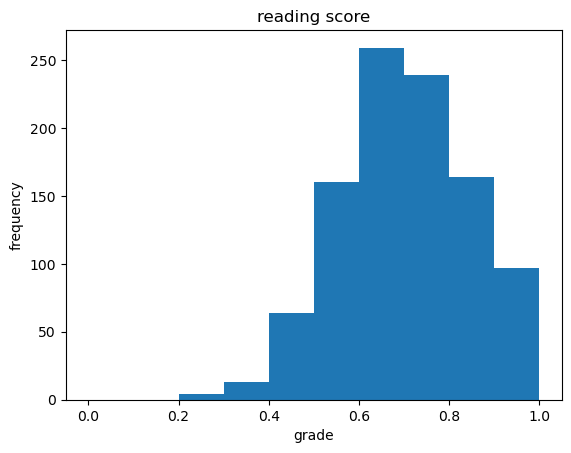

In [257]:
grade_hist(df, 'reading score', 0.1)

In [258]:
curtosis(df, 'reading score')

0.2560646900269543

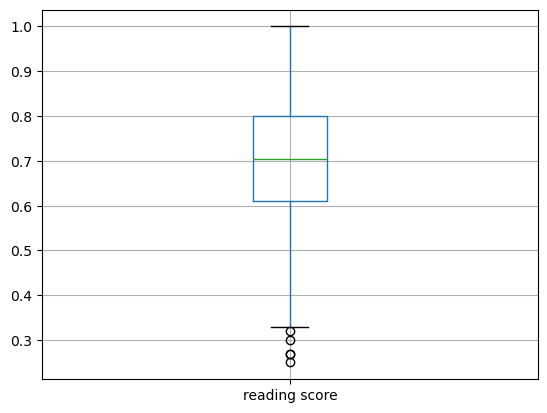

In [259]:
df.boxplot(column='reading score')
plt.show()

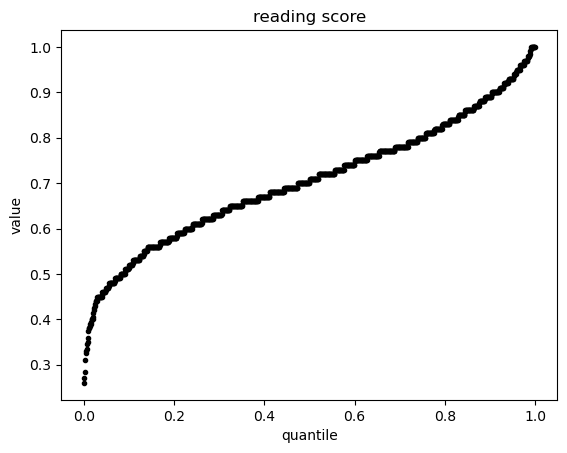

In [260]:
# gráfico de quantil (apenas uma variável)
quantile_plot(df, 'reading score')

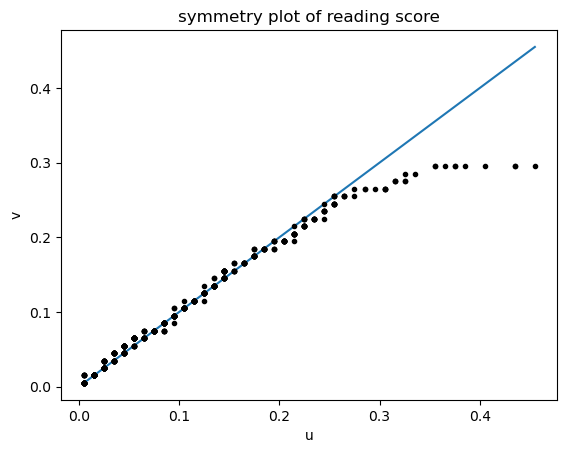

In [261]:
symmetry_plot(df, "reading score")

### Writing score

In [262]:
ws = df['writing score']
dws = described['math score']
dws

count   1000.00
mean      67.81
std       15.25
min       15.00
25%       58.00
50%       68.00
75%       79.25
max      100.00
Name: math score, dtype: float64

In [263]:
# Coeficiente de variação
"{:.2f}".format(100*dws['std']/dws['mean']) + '%'

'22.49%'

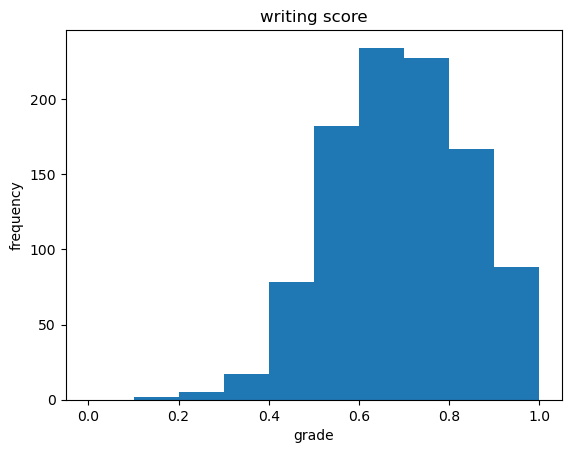

In [264]:
grade_hist(df, 'writing score', 0.1)

In [265]:
curtosis(df, 'writing score')

0.268542199488491

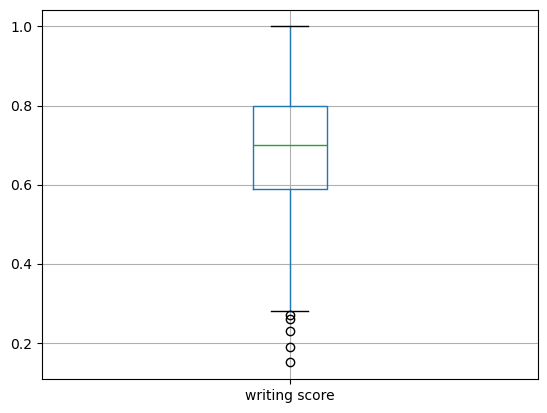

In [266]:
df.boxplot(column='writing score')
plt.show()

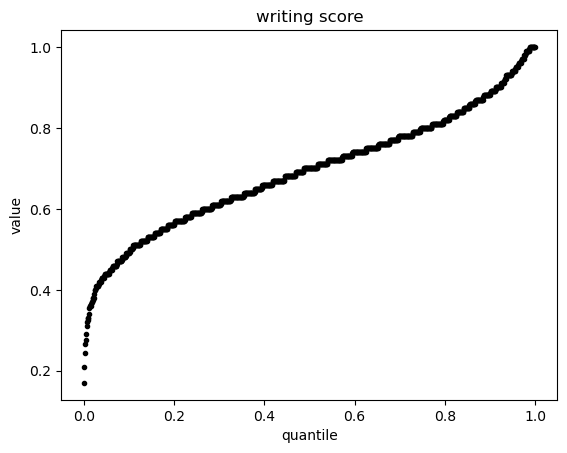

In [267]:
# gráfico de quantil (apenas uma variável)
quantile_plot(df, 'writing score')

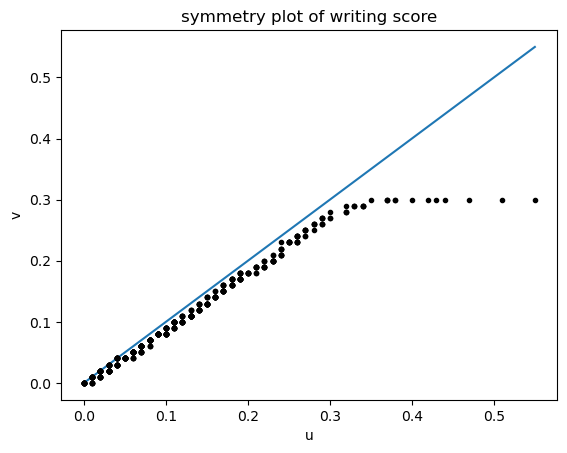

In [268]:
symmetry_plot(df, "writing score")

## Descriptive multivariate analysis and Hypothesis testing

### Categorical x Categorical

In [269]:
contigency_table = pd.crosstab(df['race/ethnicity'], df['parental level of education'], normalize='index', margins=True)
contigency_table

parental level of education,some high school,high school,some college,associate's degree,bachelor's degree,master's degree
race/ethnicity,,,,,,
group A,0.19,0.25,0.19,0.27,0.05,0.05
group B,0.17,0.22,0.20,0.21,0.14,0.07
group C,0.16,0.23,0.24,0.18,0.11,0.08
group D,0.20,0.18,0.21,0.23,0.10,0.08
group E,0.18,0.22,0.24,0.17,0.10,0.08
All,0.18,0.21,0.22,0.20,0.10,0.07


The following histogram displays the marginal distribution of parental level of education (the last row of the above table).

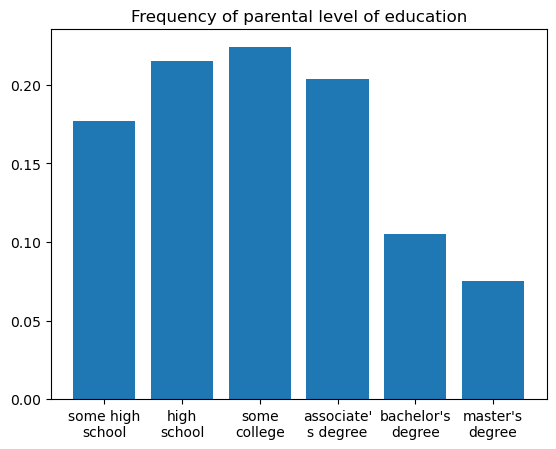

In [270]:
bar(df, 'parental level of education', normalize=True)

If there wasn't any association between race/ethnicity and parental level of education, we would expect the distribution of parental level of education grouped by race/ethnicity to be close the the marginal distribution of parental level of education. That is, if there is no association, then the assumption that a student belongs to a specific race/ethnicity should not change the resulting distribution of parental level of education.

Let us verify whether or not there is any association.

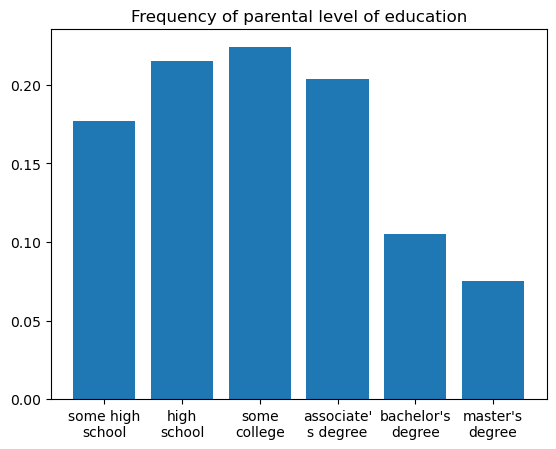

In [271]:
bar(df, 'parental level of education', normalize=True)
fig = px.histogram(
    df,
    x='race/ethnicity',
    color='parental level of education',
    barmode='group',
    barnorm='fraction',
    category_orders={
        'race/ethnicity': df['race/ethnicity'].cat.categories.tolist(),
        'parental level of education': df['parental level of education'].cat.categories.tolist()
    }
)
fig.show()

By analysing the graphs, we can conclude that:
1. Group A has the lowest overall parental level of education
2. Group B has the highest overall parental level of education
3. The remaining groups have a distribution of parental level of education very close to the marginal distribution.
4. Although groups A and B are the most distinct, their distributions of parental level of education are still somewhat close to the marginal distribution.

So there seems to be some degree small of association between the two variables. This can be statistically tested with Pearson's chi-squared ($\chi ^2$) test.

In [272]:
chi2, p_value, dof, expected = chi2_contingency(contigency_table)
print(chi2)
print(p_value)

0.10883824233170553
1.0


Using a significance level of 5%, we actually sustain the null hypothesis "parental level of education and race/ethnicity are independent" (we fail to reject the null hypothesis, but don't necessarily accept it). So, overall, we cannot conclude that there is an association between the two variables.

Another way of verifying association is by looking at what happens to the mean and the standard deviation of the parental level of education when the dataset is grouped by race/ethnicity. This only possible because the parental level of education can be naturally ordered, even though it is a categorical variable. This makes it possible to meaningfully compute the mean and the standard deviation of the parental level of education.

If there is any association between the two variables, the distributions of parental level of education grouped by race/ethnicity should have very different standard deviations and/or means when compared to the marginal distribution of parental level of education.

In [273]:
# df_coded.boxplot(column='parental level of education')
df_coded['parental level of education'].describe()[['mean', 'std']]

mean   2.07
std    1.49
Name: parental level of education, dtype: float64

In [274]:
df_coded.groupby('race/ethnicity')['parental level of education'].describe()[['mean', 'std']]

,mean,std
race/ethnicity,,
0,1.89,1.40
1,2.14,1.50
2,2.09,1.47
3,2.07,1.52
4,2.03,1.51


This corroborates the analysis we did earlier from the bar plots. The mean and standard deviation of groups C, D and E are very similar to that of the marginal distribution of parental level of education, while the mean and standard deviation of groups A and B are only mildly different.

A related measure we can use to quantify the strength of this association is the coefficient of determination, also known as $R^2$. This measures the proportion of the variance of the parental level of education explained by the introduction of the race/ethnicity.

In [275]:
r2(df_coded, 'parental level of education', 'race/ethnicity')

-0.002130802805132559

$R^2$ is between 0 and 1, so the negative result is likely due to floating point imprecision, and indicates that the true value is close to 0. We then conclude that, for this sample of students, race/ethnicity and parental level of education are not meaningfully statistically associated.

### Numerical x Categorical

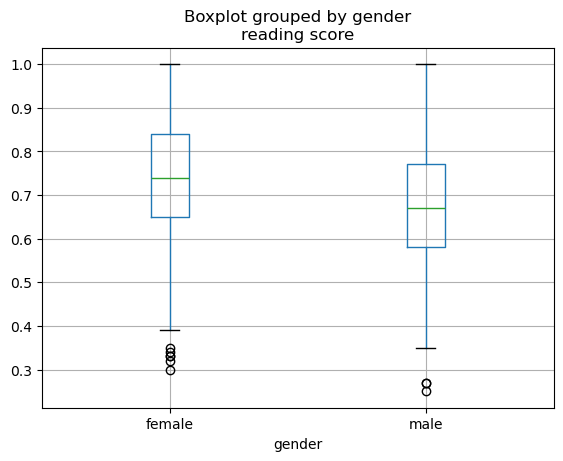

In [276]:
df.boxplot(column='reading score', by='gender')
plt.show()

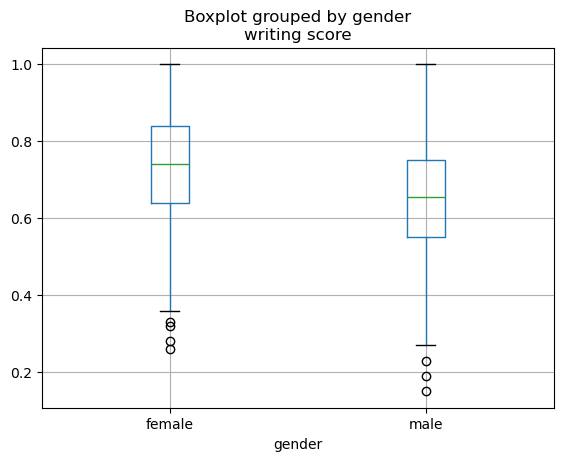

In [277]:
df.boxplot(column='writing score', by='gender')
plt.show()

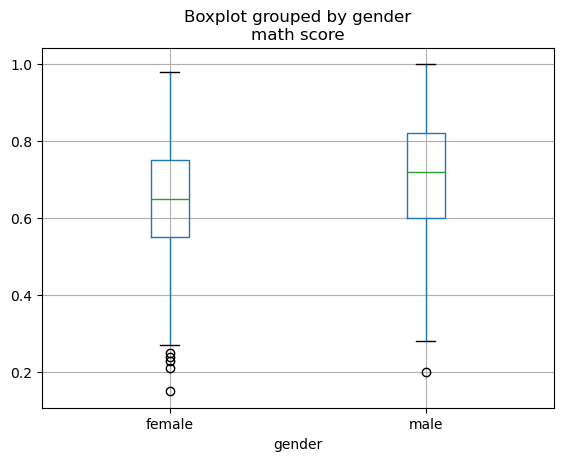

In [278]:
df.boxplot(column='math score', by='gender')
plt.show()

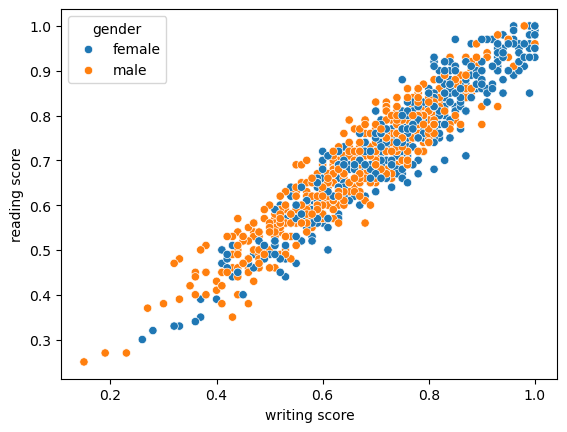

In [279]:
sb.scatterplot(df[['writing score', 'reading score', 'gender']], x='writing score', y='reading score', hue='gender')
plt.show()

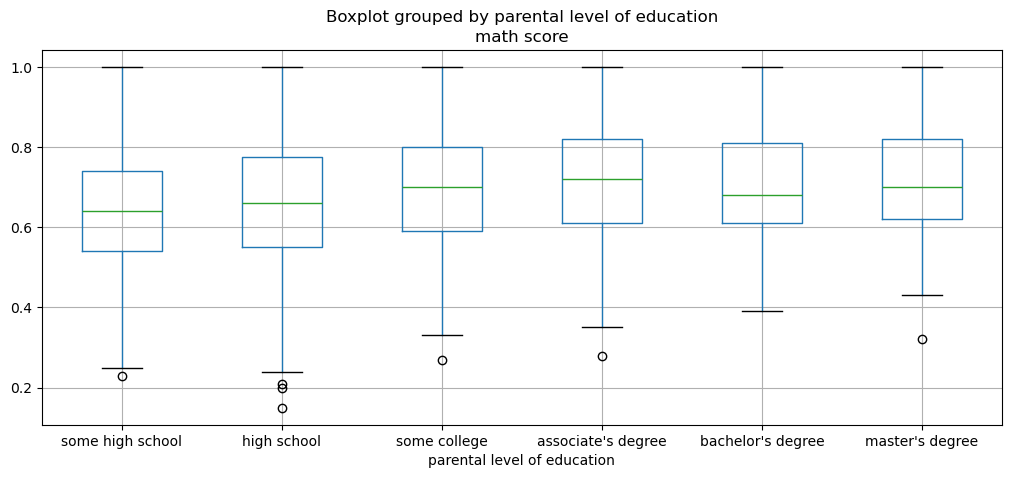

In [280]:
df.boxplot(column='math score', by='parental level of education', figsize=(12,5))
plt.show()

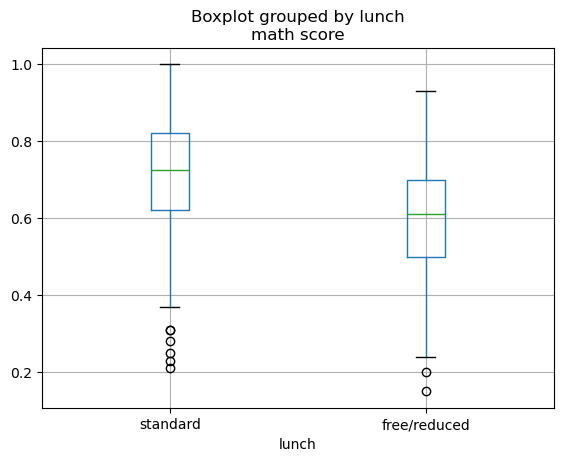

In [281]:
df.boxplot(column='math score', by='lunch')
plt.show()

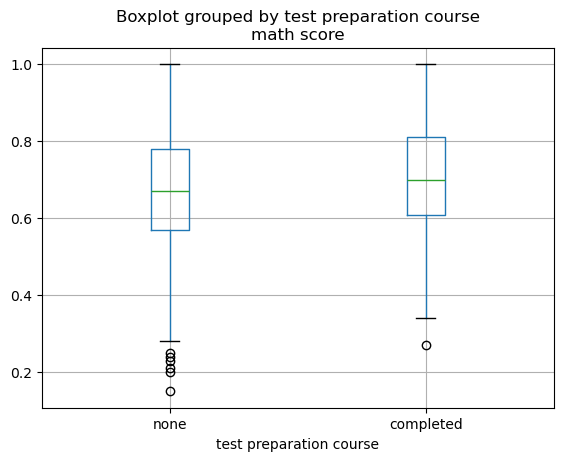

In [282]:
df.boxplot(column='math score', by='test preparation course')
plt.show()

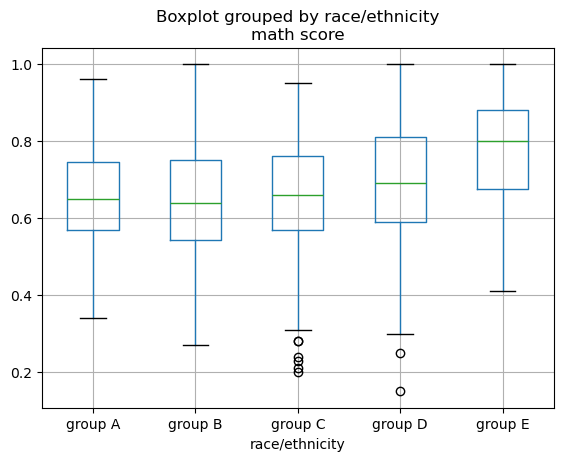

In [283]:
df.boxplot(column='math score', by='race/ethnicity')
plt.show()

### Numerical x Numerical

In [284]:
x = df["math score"]
y = df["reading score"]
z = df["writing score"]

In [285]:
fig = ff.create_scatterplotmatrix(df[["writing score", "reading score", "math score"]], diag='histogram', height=700, width=1400)
fig.show()

In [286]:
px.density_heatmap(df, x='math score', y='reading score')

In [287]:
px.density_heatmap(df, x='writing score', y='reading score')

In [288]:
correlation_matrix = df[["math score", "reading score", "writing score"]].corr().to_numpy()

heatmap_trace = go.Heatmap(z=df[["math score", "reading score", "writing score"]].corr(), x=['math score', 'reading score', 'writing score'], y=['math score', 'reading score', 'writing score'], colorscale='Viridis', zmid=0)

annotations = []
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        annotations.append(dict(x=i, y=j, text=correlation_matrix[j][i],
                                font=dict(color='white'), showarrow=False))

layout = go.Layout(title='Correlação', annotations=annotations)

fig = go.Figure(data=[heatmap_trace], layout=layout)

fig.show()

In [289]:
covariance_matrix = np.cov([x, y, z])

heatmap_trace = go.Heatmap(z=covariance_matrix, x=['math score', 'reading score', 'writing score'], y=['math score', 'reading score', 'writing score'], colorscale='Viridis', zmid=0)

annotations = []
for i in range(len(covariance_matrix)):
    for j in range(len(covariance_matrix)):
        annotations.append(dict(x=i, y=j, text=covariance_matrix[j][i],
                                font=dict(color='white'), showarrow=False))

layout = go.Layout(title='Covariância', annotations=annotations)

fig = go.Figure(data=[heatmap_trace], layout=layout)

fig.show()